In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#Machine Learning imports 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso

from sklearn.cross_validation import train_test_split
from sklearn import metrics


from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import skew

/home/raunaq/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("ad_org_train.csv")
test = pd.read_csv("ad_org_test.csv")
train.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [3]:
columns = ['views', 'likes', 'dislikes', 'comment']
for column in columns:
        train[column] = train[column].apply(pd.to_numeric, errors = 'coerce')
        test[column] = test[column].apply(pd.to_numeric, errors = 'coerce')        
        print (column, train[column].isnull().sum())
        print (column, test[column].isnull().sum())

views 2
views 1
likes 155
likes 88
dislikes 155
dislikes 88
comment 233
comment 151


In [4]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [5]:
def time_transform(data):
    duration = data['duration']
    h_pos = 0
    m_pos = 0
    s_pos = len(duration) - 1
    time = 0
    #duration = list(duration)
    if 'H' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'H':
                h_pos = i
                break
        time = int(duration[2:h_pos]) * 3600 

    if 'M' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'M':
                m_pos = i
                break
        if 'H' in duration:
            time = time + int(duration[h_pos+1:m_pos]) * 60
        else:
            time = int(duration[2:m_pos]) * 60
        
        if 'S' in duration:
            time = time + int(duration[m_pos+1:s_pos])
        
    else:
        if 'H' not in duration:
            time = time + int(duration[2:s_pos])
        else:
            time = time + int(duration[h_pos+1:s_pos])
    #print (duration, m_pos)
    #time = str(time)
    #print (time)
    data['duration'] = time
    data.head()
    return data

train = train.apply(time_transform, axis=1)
test = test.apply(time_transform, axis=1)

In [6]:
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['category'].values))
train['category'] = lbl.transform(list(train['category'].values))
test['category'] = lbl.transform(list(test['category'].values))

In [7]:
train['published'] = pd.to_datetime(train['published'])
test['published'] = pd.to_datetime(test['published'])

train['dayofweek'] = train.published.dt.dayofweek
test['dayofweek'] = test.published.dt.dayofweek
#quarter didn't work
#weekofyear didn't work

train['year'] = train.published.dt.year
test['year'] = test.published.dt.year

train['month'] = train.published.dt.month
test['month'] = test.published.dt.month

train.drop(['published'], axis=1, inplace=True)
test.drop(['published'], axis=1, inplace=True)

In [8]:
test.drop(['vidid'], axis=1, inplace=True)
train.drop(['vidid'], axis=1, inplace=True)

In [9]:
train.head()

,adview,views,likes,dislikes,comment,duration,category,dayofweek,year,month
0,40,1031602.0,8523.0,363.0,1095.0,457,5,2,2016,9
1,2,1707.0,56.0,2.0,6.0,570,3,5,2016,10
2,1,2023.0,25.0,0.0,2.0,136,2,5,2016,7
3,6,620860.0,777.0,161.0,153.0,262,7,2,2016,7
4,1,666.0,1.0,0.0,0.0,31,3,2,2016,6


In [10]:
columns = ['adview', 'views', 'likes', 'dislikes', 'comment']
for x in columns:
    temp = train[x]
    mean = temp.mean()
    std = temp.std()
    final_list = [z for z in temp if (z > mean - 2 * std)]
    final_list = [z for z in final_list if (z < mean + 2*std)]
    temp = Series(final_list)
    train[x] = temp
    print (x, train[x].isnull().sum())

adview 403
views 557
likes 710
dislikes 582
comment 705


In [11]:
train.shape

(14637, 10)

In [12]:
train.dropna(inplace=True)

In [13]:
train.shape

(13927, 10)

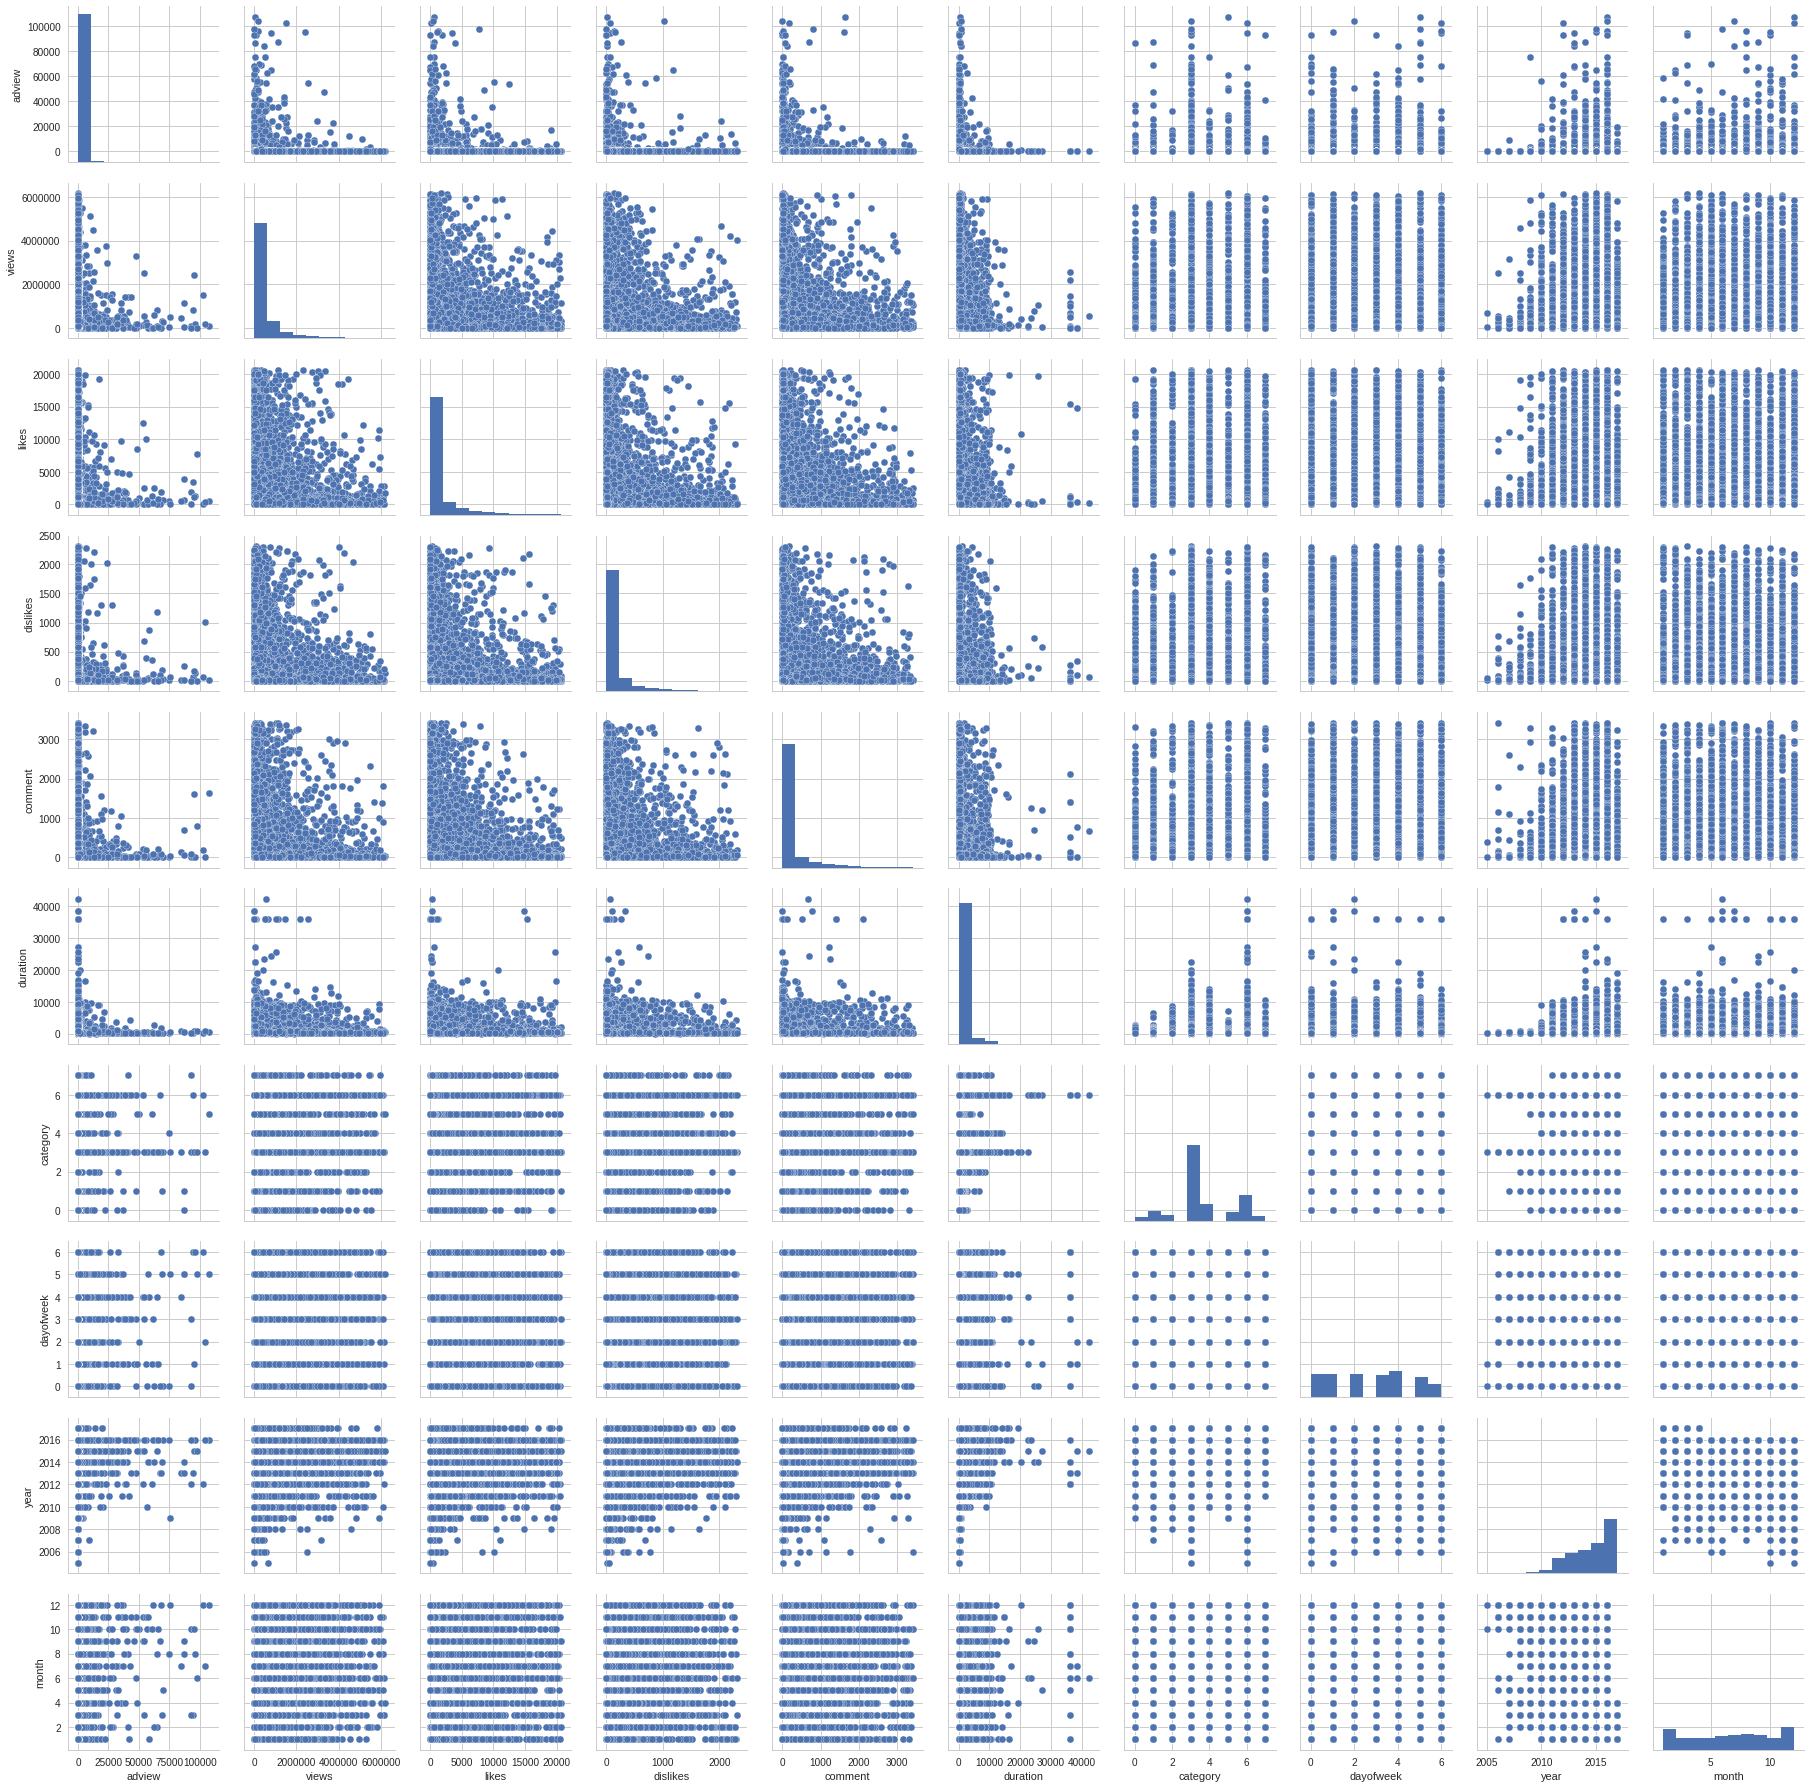

In [14]:
sns.pairplot(train)

In [15]:
columns = ['adview', 'views', 'likes', 'dislikes', 'comment', 'duration']

In [16]:
std_scaler = preprocessing.StandardScaler()
std_scaler.fit(train[columns])
train[columns] = std_scaler.transform(train[columns])

In [17]:
train.head()

,adview,views,likes,dislikes,comment,duration,category,dayofweek,year,month
0,-0.108964,0.604721,2.047686,0.601916,1.723969,-0.252815,5,2,2016,9
1,-0.117409,-0.570379,-0.513878,-0.499444,-0.468475,-0.204196,3,5,2016,10
2,-0.117631,-0.570018,-0.523256,-0.505546,-0.476528,-0.390926,2,5,2016,7
3,-0.116520,0.136069,-0.295750,-0.014357,-0.172525,-0.336714,7,2,2016,7
4,-0.117631,-0.571567,-0.530517,-0.505546,-0.480554,-0.436103,3,2,2016,6


In [18]:
y_train = train['adview']
train.drop(['adview'],axis =1, inplace=True)

Random Forests
MAE : 0.237261
RMSE : 0.952567
Auc: 0.422707


model_score 0.855345215429


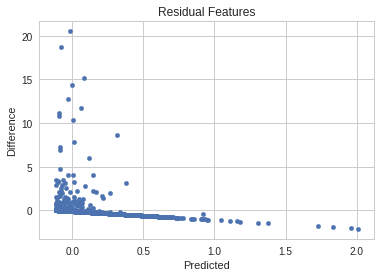

Ridge Regression
MAE : 0.213334
RMSE : 0.933538
Auc: 0.234207


model_score 0.00127999078411


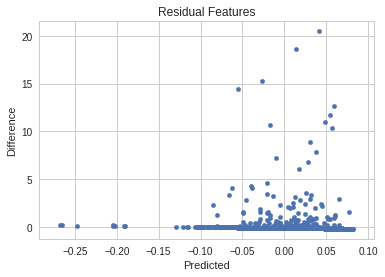

Lasso Regression
MAE : 0.213445
RMSE : 0.933807
Auc: 0.050996


model_score 0.0


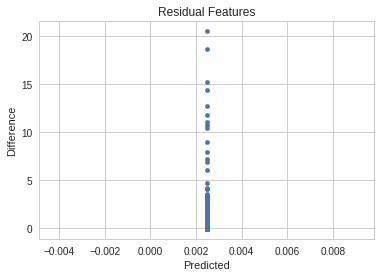

MLP (NN)
MAE : 0.213579
RMSE : 0.933423
Auc: 0.224286


model_score 0.000394321191702


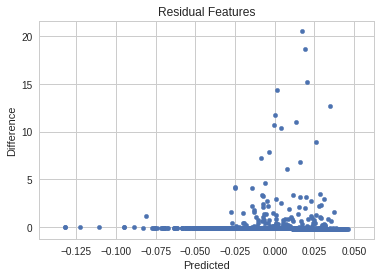

In [21]:
def display_metrics(y_test, y_pred):
    print ("MAE : %f" % metrics.mean_absolute_error(y_test, y_pred))
    print ("RMSE : %f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    #print ("NRMSE : %f" % np.mean(np.abs((y_test - y_pred)/y_test)) * 100)
    print ("Auc: %f" % metrics.auc(y_test, y_pred,reorder=True))
    #print ("fbeta: %f" % metrics.fbeta_score(y_test, y_pred, beta=2))
    print ("\n")
           
def model_train(model,X,y):
    # Split test, train
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_metrics(y_test, y_pred)
    
    print ('model_score', model.score(X_train, y_train))
    
    plt.figure(figsize= (50,10))
    preds = pd.DataFrame({"Predicted":model.predict(X_test), "true":y_test})
    preds["Difference"] = preds["true"] - preds["Predicted"]
    preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features")
    plt.show()
    
def training(X,y):   
    
    #Random Forests
    rand_clf = RandomForestRegressor(n_estimators = 300,max_features='sqrt')
    print ("Random Forests")
    model_train(rand_clf, X, y)

    #Ridge Regression
    ridge_clf = Ridge(alpha=0.001, normalize=True)
    print ("Ridge Regression")
    model_train(ridge_clf, X, y)
    
    #Lasso Regression
    lasso_clf = Lasso(alpha=0.001, normalize=True)
    print ("Lasso Regression")
    model_train(lasso_clf, X, y)
    
    #MLP Regression
    mlp_clf = MLPRegressor(solver = 'lbfgs', alpha = 0.01, hidden_layer_sizes=(10,10), random_state= 1)
    print ("MLP (NN)")
    model_train(mlp_clf, X, y)
    
    
    return rand_clf, mlp_clf, ridge_clf, lasso_clf

rand_reg,ridge_reg, lasso_reg, mlp_reg = training(train, y_train)
